In [3]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

In [4]:
raw_df = pd.read_csv('realtime2.csv', sep=',', names=['vehicle_id', 'timestamp', 'lat', 'lon'], header=None)

In [5]:
geometry = [Point(xy) for xy in zip(raw_df['lat'], raw_df['lon'])]
gdf = GeoDataFrame(raw_df, geometry=geometry)

In [19]:
import json
import psycopg2

In [24]:
conn = psycopg2.connect(dbname="gis", user="docker", password="docker", host="localhost", port="5434")

In [26]:
trajectories = gpd.read_postgis("SELECT * FROM tmp_trajectories", conn, coerce_float=False)

In [27]:
trajectories.to_pickle('trajectories.pkl')

In [6]:
raw_df.head()

,vehicle_id,timestamp,lat,lon,geometry
0,vehicle:ARR:25080:7090,1563120831,51.460632,5.792649,POINT (51.46063194529502 5.792648976852812)
1,vehicle:ARR:13308:30857,1563120831,52.112858,6.305586,POINT (52.11285759565716 6.30558609768796)
2,vehicle:ARR:14380:3855,1563120831,52.749480,6.875784,POINT (52.74947965309775 6.875783610146259)
3,vehicle:ARR:17875:7046,1563120831,51.997610,4.577926,POINT (51.99760952280822 4.577926277875783)
4,vehicle:ARR:22803:7535,1563120831,51.570079,5.052483,POINT (51.570078852294 5.052483229763348)


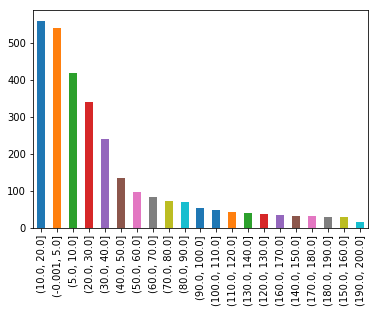

In [17]:
occurences = raw_df['vehicle_id'].value_counts()
bins = pd.cut(occurences, bins=[0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], include_lowest=True)
bins.value_counts().plot.bar()

In [39]:
from scipy.spatial import cKDTree  
import numpy as np
def ckdnearest(gdA, gdB, bcol):   
#     nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
#     nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    nA = np.array(list(zip(gdA.lat, gdA.lon)) )
    nB = np.array(list(zip(gdB.lat, gdB.lon)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist.astype(int),
                             'bcol' : gdB.loc[idx, bcol].values })
    return df

In [51]:
trajectories = pd.read_pickle('trajectories.pkl')

In [52]:
from shapely.ops import nearest_points

vehicle = {}
for vehicle_id, group in raw_df.groupby('vehicle_id'):
    for row in group.iterrows(): 
        result = ckdnearest(trajectories, trajectories, 'vehicle_id')
        print('result for: ',vehicle_id, ' and ', result)
        break
    break

vehicle

AttributeError: 'GeoDataFrame' object has no attribute 'lat'

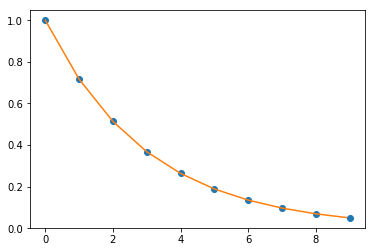

In [64]:
from scipy import interpolate

x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

# y

xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`

plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

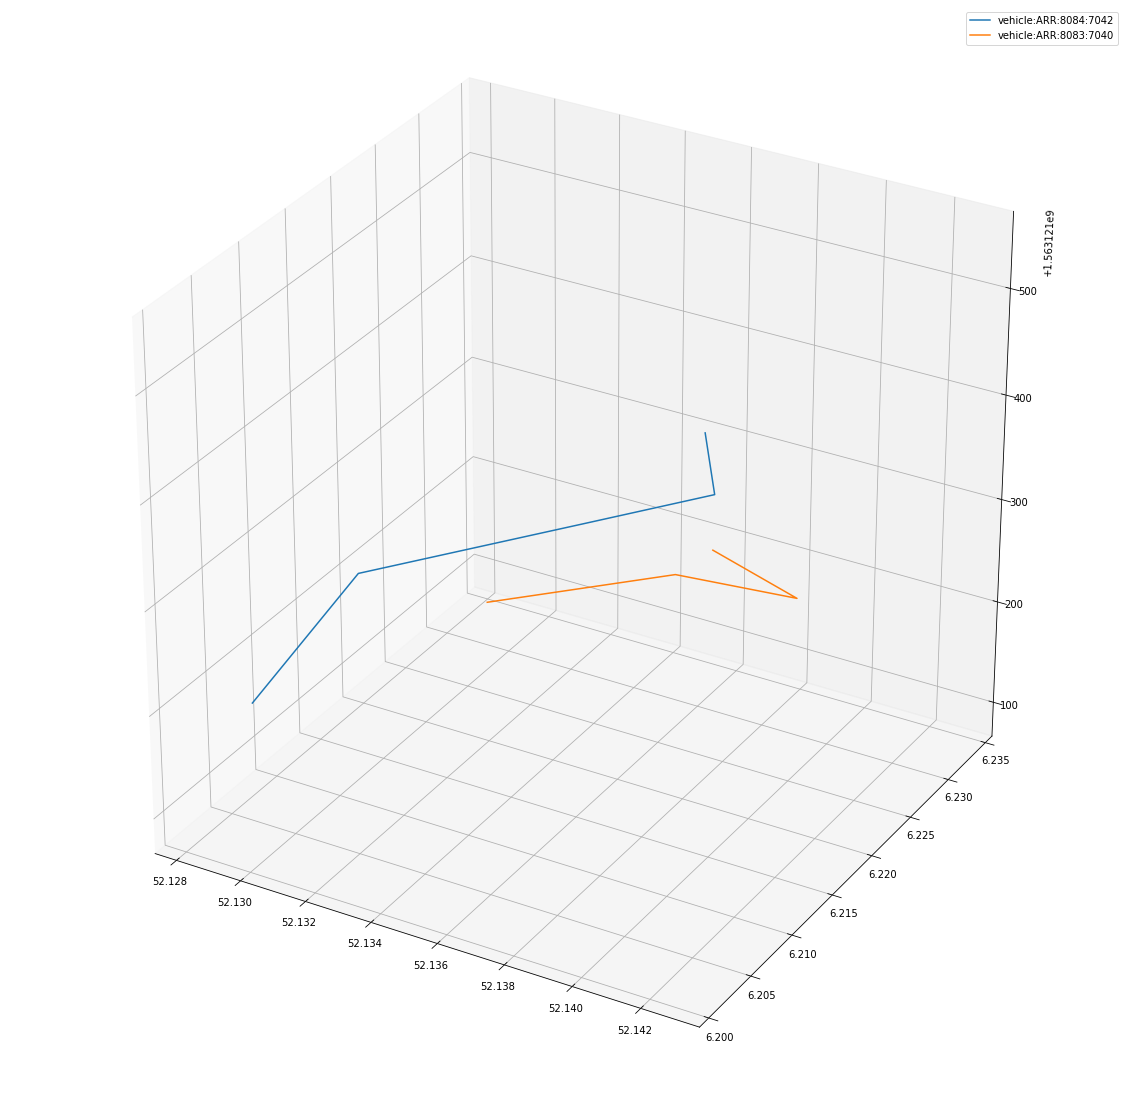

In [78]:
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)

# for vehicle_id, group in raw_df.groupby('vehicle_id'):
#     z = list(group['timestamp'])
#     x = list(group['lat'])
#     y = list(group['lon'])
    
#     ax.plot(x, y, z, label=vehicle_id)
#     ax.legend()

vehicle_ids = ['vehicle:ARR:8084:7042', 'vehicle:ARR:8083:7040']

for vehicle_id in vehicle_ids: 
    
    vehicle = raw_df[raw_df['vehicle_id'] == vehicle_id]
    z = list(vehicle['timestamp'])
    x = list(vehicle['lat'])
    y = list(vehicle['lon'])
    
    ax.plot(x, y, z, label=vehicle_id)
    ax.legend()
    
    
# vehicle = raw_df[raw_df['vehicle_id'] == 'vehicle:ARR:8083:7040']
# z1 = list(vehicle['timestamp'])
# x1 = list(vehicle['lat'])
# y1 = list(vehicle['lon'])

# ax.plot(x1, y1, z1, label='vehicle:ARR:25080:7090')
# ax.legend()


# vehicle = raw_df[raw_df['vehicle_id'] == 'vehicle:ARR:8084:7042']
# z1 = list(vehicle['timestamp'])
# x1 = list(vehicle['lat'])
# y1 = list(vehicle['lon'])

# ax.plot(x1, y1, z1, label='vehicle:ARR:13308:30857')


plt.show()